In [1]:
%pylab inline 
import pandas as pd
bb_info = pd.read_csv('computed_my_COCO_BBvals.csv')

Populating the interactive namespace from numpy and matplotlib


In [2]:
obj_sorted_tbl =  bb_info[bb_info['Jaccard [COCO]']!=-1][bb_info['Jaccard [Self]']!=0].sort('object_id')

/Users/dorislee/.virtualenvs/py27dev/lib/python2.7/site-packages/pandas/core/frame.py:1825: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  "DataFrame index.", UserWarning)


In [3]:
object_id_lst  = list(set(obj_sorted_tbl.object_id))

In [4]:
from scipy import stats

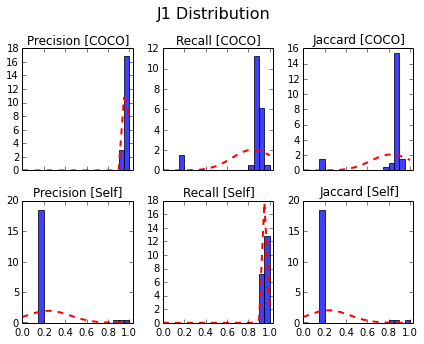

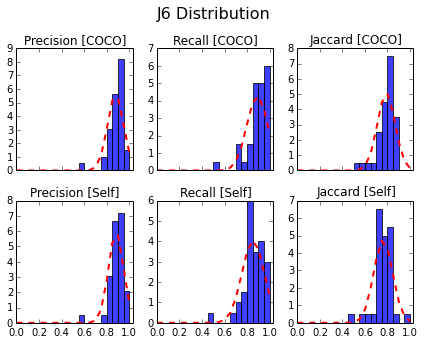

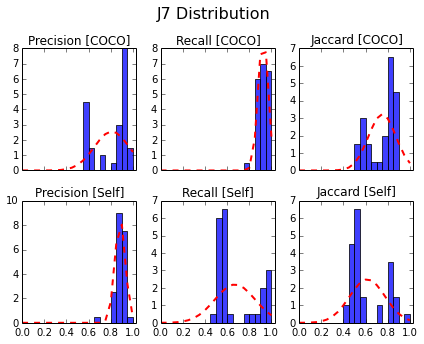

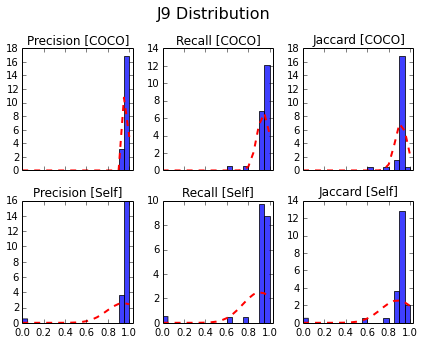

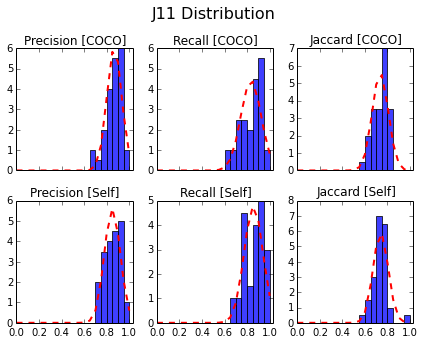

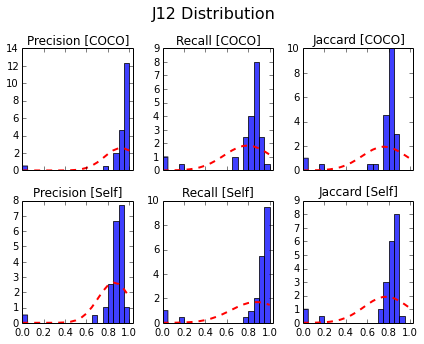

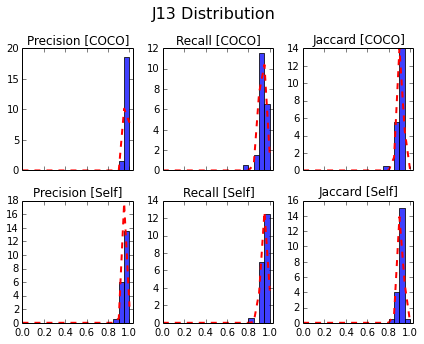

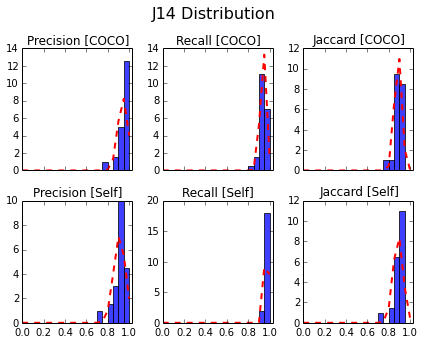

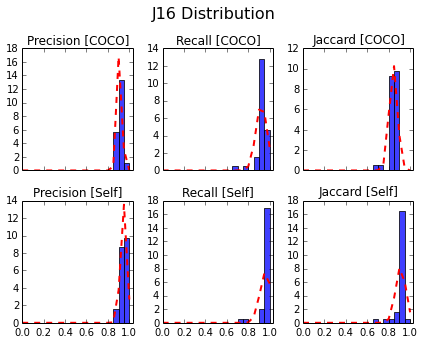

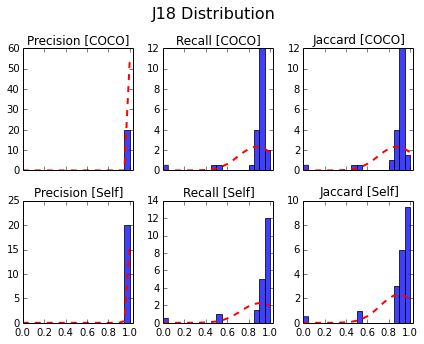

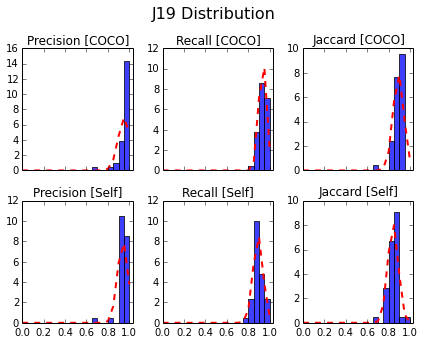

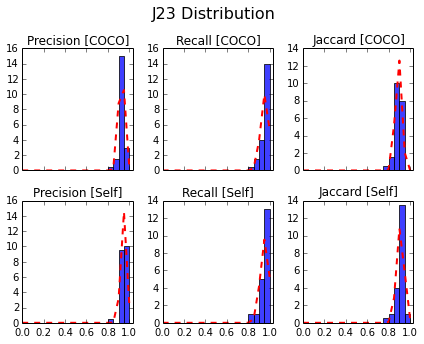

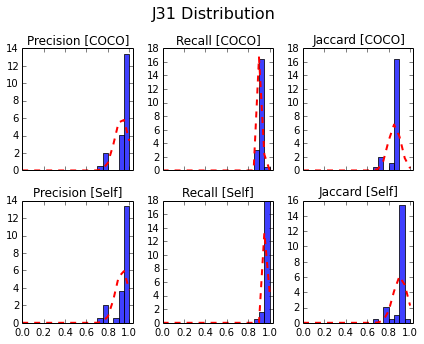

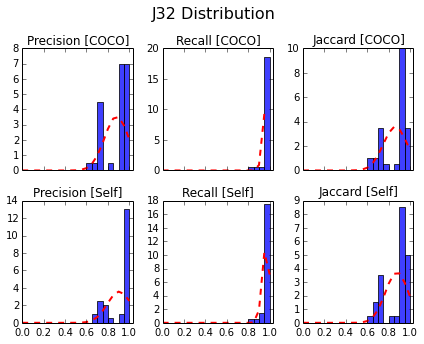

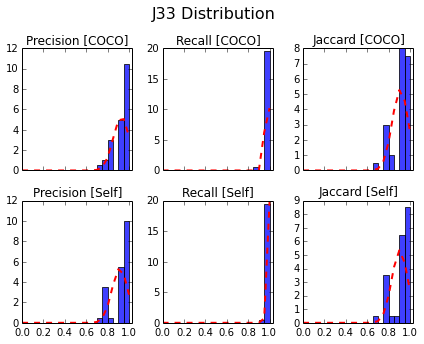

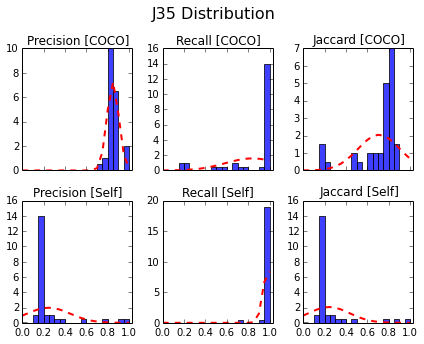

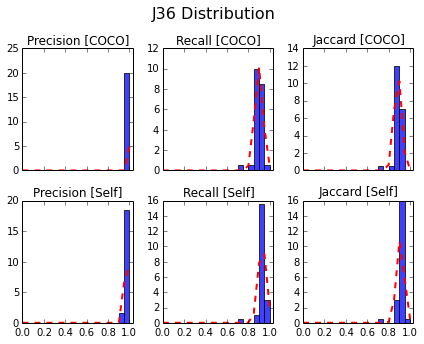

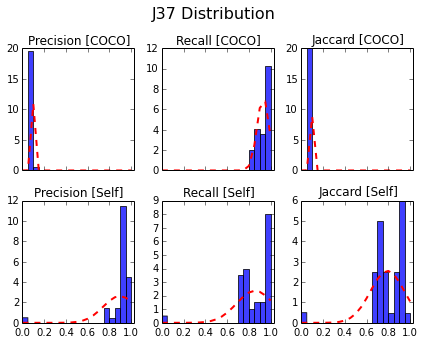

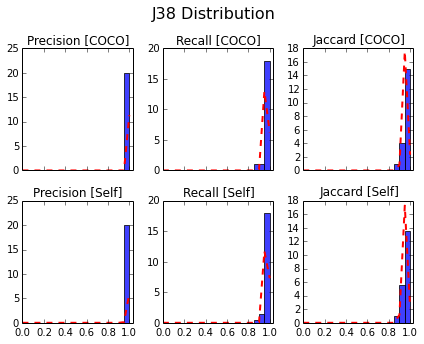

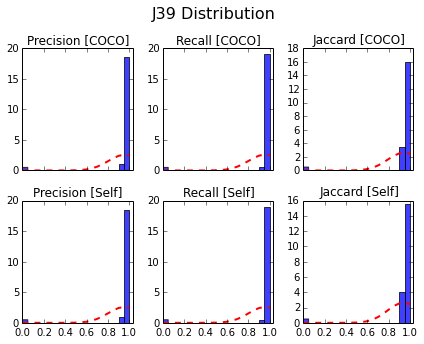

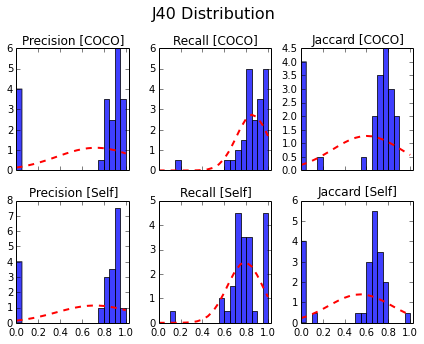

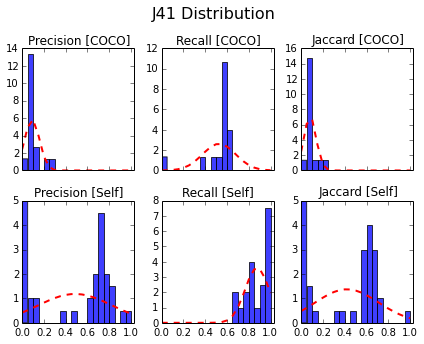

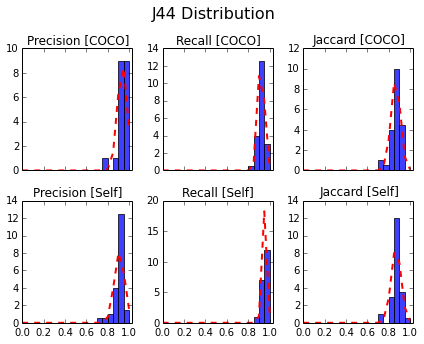

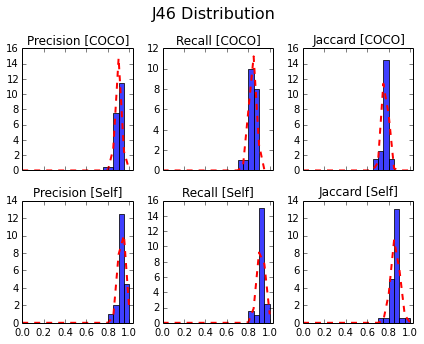

In [12]:
fcn  = stats.norm
metrics_lst = ['Precision [COCO]','Recall [COCO]','Jaccard [COCO]',\
               'Precision [Self]','Recall [Self]','Jaccard [Self]']
NUM_COL = 3
NUM_ROW = 2
NUM_PLOTS = NUM_COL*NUM_ROW

for objid in object_id_lst:
    fig, axs = plt.subplots(NUM_ROW,NUM_COL, figsize=(NUM_ROW*3,NUM_COL*1.5), sharex='col')
    stitle = fig.suptitle("J{} Distribution ".format(objid),fontsize=16,y=1.05)
    axs = axs.ravel()
    # Ji is the set of all workers that annotated object i 
    Ji_tbl = obj_sorted_tbl[obj_sorted_tbl["object_id"]==objid]
    bb_info = Ji_tbl
    for i,metric in zip(range(len(metrics_lst)),metrics_lst):
        metric_value = np.array(bb_info[metric][bb_info[metric]>0][bb_info[metric]<=1]) 
        ax = axs[i]
        ax.set_title(metric)
        #ax.hist(metric_value,bins=30)
        ax.set_xlim(0,1.03)

        metric_value = np.array(bb_info[metric][bb_info[metric]>0][bb_info[metric]<=1]) 
        params = fcn.fit(metric_value)
    #     histo,bin_edges = np.histogram(metric_value, 50, normed=1)
    #     bins = ((bin_edges+np.roll(bin_edges,-1))/2)[:-1]
        n, bins, patches = ax.hist(metric_value, 20, normed=1, range=(0,1),facecolor='blue', alpha=0.75)
        y = fcn.pdf(bins, *params)
        l = ax.plot(bins, y, 'r--', linewidth=2) 

    fig.tight_layout()
# fig.savefig('{}_fitted_worker_histogram.pdf'.format(fcn.name), bbox_inches='tight',bbox_extra_artists=[stitle])

need to add range=(0,1) in order to have even bins across all ranges, otherwise, if not provided range is min(x) and max(x) which is different for each data , so the number of entries in x is different for each dataset, differing bar width makes it hard for the results to be interpretable and tune binsize 

## RSS and KS test result for fitting norm

Testing other functions is unneccesary since Gaussian is a "good-enough" fit, that would be a simple and interpretable parameterization $\Phi$

- no shape information
- loc = mean
- scale = SD 

In [5]:
from analysis_toolbox import *

In [6]:
fcn  = stats.norm
SHOW_PLOT=False
metrics_lst = ['Precision [COCO]','Recall [COCO]','Jaccard [COCO]',\
               'Precision [Self]','Recall [Self]','Jaccard [Self]']
NUM_COL = 3
NUM_ROW = 2
NUM_PLOTS = NUM_COL*NUM_ROW
data_fit_stats=[]
for objid in object_id_lst:
    if SHOW_PLOT:
        fig, axs = plt.subplots(NUM_ROW,NUM_COL, figsize=(NUM_ROW*3,NUM_COL*1.5), sharex='col')
        stitle = fig.suptitle("J{} Distribution ".format(objid),fontsize=16,y=1.05)
        axs = axs.ravel()
    # Ji_tbl (bb_info) is the set of all workers that annotated object i 
    bb_info  = obj_sorted_tbl[obj_sorted_tbl["object_id"]==objid]

    for i,metric in zip(range(len(metrics_lst)),metrics_lst):
#         table_data.append(basic_stat(metric_value,metric))
        metric_value = np.array(bb_info[metric][bb_info[metric]>0][bb_info[metric]<=1]) 
        params = fcn.fit(metric_value)
        histo,bin_edges = np.histogram(metric_value, 40, normed=1)
        bins = ((bin_edges+np.roll(bin_edges,-1))/2)[:-1]
        y = fcn.pdf(bins, *params)
        RSS =sum((histo-y)**2)
        ks_result = kolmogorov_smirnov(bins,y,"Gaussian") #D-value and p-value
        # object_id, Metric, mu, sd,RSS,D-value,p-value
        data_stats  = [objid,metric,params[0],params[1],RSS,ks_result[0],ks_result[1]] 
        #same as what you would get if you did basic_stats because in the MLE estimate, mu and sigma is equal to sample mean and sample sd
        data_fit_stats.append(data_stats)
        if SHOW_PLOT:
            ax = axs[i]
            ax.set_title(metric)
            #ax.hist(metric_value,bins=30)
            ax.set_xlim(0,1.03)
            n, bins, patches = ax.hist(metric_value, 40, normed=1, range=(0,1),facecolor='blue', alpha=0.75)
            y = fcn.pdf(bins, *params)
            l = ax.plot(bins, y, 'r--', linewidth=2) 

    if SHOW_PLOT: fig.tight_layout()
# fig.savefig('{}_fitted_worker_histogram.pdf'.format(fcn.name), bbox_inches='tight',bbox_extra_artists=[stitle])

In [7]:
gaussian_fit_results =pd.DataFrame(data_fit_stats,columns=["object_id", "Metric", "Mean", "SD","RSS","D-value","p-value"])

In [8]:
#The fitting is not really statistically significant, average RSS is quite large too 
print gaussian_fit_results.RSS.mean()
gaussian_fit_results[gaussian_fit_results["p-value"]>0.5]

4270.7725604


,object_id,Metric,Mean,SD,RSS,D-value,p-value


In [9]:
gaussian_fit_results

,object_id,Metric,Mean,SD,RSS,D-value,p-value
0,1,Precision [COCO],0.972499,0.021205,7131.800417,0.925,2.887954e-16
1,1,Recall [COCO],0.843183,0.194542,546.841966,0.450,3.565228e-04
2,1,Jaccard [COCO],0.823547,0.189367,587.590150,0.475,1.330354e-04
3,1,Precision [Self],0.244087,0.202222,1771.226787,0.375,4.984225e-03
4,1,Recall [Self],0.957798,0.020984,4362.277369,0.975,5.033001e-18
5,1,Jaccard [Self],0.240031,0.193926,1760.931862,0.400,2.182240e-03
6,6,Precision [COCO],0.878793,0.071300,354.224431,0.550,5.020623e-06
7,6,Recall [COCO],0.890581,0.093161,132.619635,0.550,5.020623e-06
8,6,Jaccard [COCO],0.788697,0.079127,316.550276,0.650,3.014130e-08
9,6,Precision [Self],0.882589,0.067549,182.706039,0.600,4.327560e-07


### Since gaussian isn't great, Try fitting to other functions 

In [6]:
exclude= ['division', 'skellam', 'nbinom', 'logser', 'erlang','dlaplace', 'hypergeom', 'bernoulli', 'levy_stable', 'zipf', 'rv_discrete', 'rv_frozen', 'boltzmann', 'rv_continuous', 'entropy', 'randint', 'poisson', 'geom', 'binom', 'planck', 'print_function']
fcn_lst =  filter(lambda x: x not in exclude,dir(stats.distributions)[9:])

alpha : D = 0.2 ; p =0.77 ---> from same distribution
beta : D = 0.4 ; p =0.06 ---> from same distribution
betaprime : D = 0.4 ; p =0.06 ---> from same distribution
chi : D = 0.4 ; p =0.06 ---> from same distribution
chi2 : D = 0.35 ; p =0.13 ---> from same distribution
dweibull : D = 0.35 ; p =0.13 ---> from same distribution
dweibull : D = 0.35 ; p =0.13 ---> from same distribution
exponpow : D = 0.25 ; p =0.5 ---> from same distribution
exponpow : D = 0.25 ; p =0.5 ---> from same distribution
f : D = 0.4 ; p =0.06 ---> from same distribution
f : D = 0.4 ; p =0.06 ---> from same distribution
fatiguelife : D = 0.4 ; p =0.06 ---> from same distribution
fatiguelife : D = 0.4 ; p =0.06 ---> from same distribution
fatiguelife : D = 0.35 ; p =0.13 ---> from same distribution
fatiguelife : D = 0.4 ; p =0.06 ---> from same distribution
foldnorm : D = 0.35 ; p =0.13 ---> from same distribution
foldnorm : D = 0.35 ; p =0.13 ---> from same distribution
frechet_l : D = 0.35 ; p =0.13 ---> from s

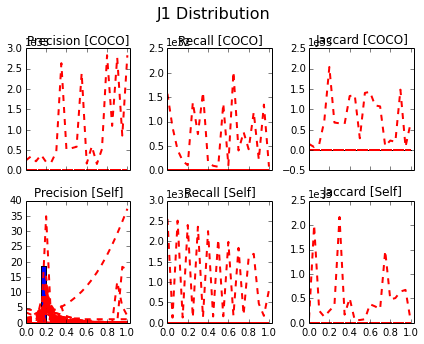

In [29]:
SHOW_PLOT=True
metrics_lst = ['Precision [COCO]','Recall [COCO]','Jaccard [COCO]',\
               'Precision [Self]','Recall [Self]','Jaccard [Self]']
NUM_COL = 3
NUM_ROW = 2
NUM_PLOTS = NUM_COL*NUM_ROW
data_fit_stats=[]
i=0
for objid in object_id_lst:
    if i<2:
        if SHOW_PLOT:
            fig, axs = plt.subplots(NUM_ROW,NUM_COL, figsize=(NUM_ROW*3,NUM_COL*1.5), sharex='col')
            stitle = fig.suptitle("J{} Distribution ".format(objid),fontsize=16,y=1.05)
            axs = axs.ravel()
        # Ji_tbl (bb_info) is the set of all workers that annotated object i 
        bb_info  = obj_sorted_tbl[obj_sorted_tbl["object_id"]==objid]
        for fcn_name in fcn_lst:
            fcn = getattr(stats,fcn_name)
            for i,metric in zip(range(len(metrics_lst)),metrics_lst):
        #         table_data.append(basic_stat(metric_value,metric))
                metric_value = np.array(bb_info[metric][bb_info[metric]>0][bb_info[metric]<=1]) 
                params = fcn.fit(metric_value)
                histo,bin_edges = np.histogram(metric_value, 20, range=(0,1),normed=1)
                bins = ((bin_edges+np.roll(bin_edges,-1))/2)[:-1]
                y = fcn.pdf(bins, *params)
                RSS =sum((histo-y)**2)
                ks_result = kolmogorov_smirnov(bins,y,fcn.name) #D-value and p-value
                # object_id, Metric,Function, mu, sd,RSS,D-value,p-value
                data_stats  = [objid,metric, fcn_name,params[0],params[1],RSS,ks_result[0],ks_result[1]] 
                #same as what you would get if you did basic_stats because in the MLE estimate, mu and sigma is equal to sample mean and sample sd
                data_fit_stats.append(data_stats)
                if SHOW_PLOT:
                    ax = axs[i]
                    ax.set_title(metric)
                    #ax.hist(metric_value,bins=30)
                    ax.set_xlim(0,1.03)
                    n, bins, patches = ax.hist(metric_value, 20, normed=1, range=(0,1),facecolor='blue', alpha=0.75)
                    y = fcn.pdf(bins, *params)
                    l = ax.plot(bins, y, 'r--', linewidth=2) 

            if SHOW_PLOT: fig.tight_layout()
        i+=1
    else:
        break
    # fig.savefig('{}_fitted_worker_histogram.pdf'.format(fcn.name), bbox_inches='tight',bbox_extra_artists=[stitle])

In [14]:
fit_results =pd.DataFrame(data_fit_stats,columns=["object_id", "Metric", "Function","Mean", "SD","RSS","D-value","p-value"])

In [17]:
fit_results[fit_results["p-value"]>0.5]

,object_id,Metric,Function,Mean,SD,RSS,D-value,p-value
283,1,Recall [COCO],levy,0.092543,0.476970,653.154746,0.125,0.893086
284,1,Jaccard [COCO],levy,0.093234,0.463932,701.067562,0.125,0.893086


In [16]:
fit_results[fit_results["p-value"]>0.1]

,object_id,Metric,Function,Mean,SD,RSS,D-value,p-value
135,1,Precision [Self],frechet_r,0.510298,0.173717,1191.744568,0.250,0.139252
283,1,Recall [COCO],levy,0.092543,0.476970,653.154746,0.125,0.893086
284,1,Jaccard [COCO],levy,0.093234,0.463932,701.067562,0.125,0.893086
339,1,Precision [Self],nakagami,0.137724,0.173717,1236.206004,0.225,0.230740
341,1,Jaccard [Self],nakagami,0.128941,0.172608,1227.606694,0.250,0.139252
495,1,Precision [Self],weibull_min,0.510298,0.173717,1191.744568,0.250,0.139252


In [27]:
idx = fit_results.groupby(['Metric'])['p-value'].transform(max) ==fit_results["p-value"]
fit_results[idx]

,object_id,Metric,Function,Mean,SD,RSS,D-value,p-value
16,1,Recall [Self],arcsine,0.939805,0.060195,6626.388416,0.625,1.172933e-07
283,1,Recall [COCO],levy,0.092543,0.476970,653.154746,0.125,8.930857e-01
284,1,Jaccard [COCO],levy,0.093234,0.463932,701.067562,0.125,8.930857e-01
339,1,Precision [Self],nakagami,0.137724,0.173717,1236.206004,0.225,2.307405e-01
341,1,Jaccard [Self],nakagami,0.128941,0.172608,1227.606694,0.250,1.392522e-01
384,1,Precision [COCO],powerlognorm,0.000104,0.041269,13503.254665,0.350,1.079322e-02
406,1,Recall [Self],rdist,1.048810,0.957776,7865.993752,0.625,1.172933e-07


If you decrease the bin size, this would fit a lot of function

I think a bin size of 20 is reasonable, this way, even though many function would be matching, gaussian is one of the matching ones, it is more interpretable

In [50]:
len(object_id_lst)*len(metrics_lst)

144

In [62]:
import ast

29.774999999999999

J1Precision [Self] : D = 0.4 ; p =0.06 ---> from same distribution
J1Jaccard [Self] : D = 0.4 ; p =0.06 ---> from same distribution
J9Jaccard [Self] : D = 0.4 ; p =0.06 ---> from same distribution
J12Precision [Self] : D = 0.4 ; p =0.06 ---> from same distribution
J12Recall [Self] : D = 0.4 ; p =0.06 ---> from same distribution
J18Recall [COCO] : D = 0.4 ; p =0.06 ---> from same distribution
J18Jaccard [COCO] : D = 0.4 ; p =0.06 ---> from same distribution
J18Recall [Self] : D = 0.4 ; p =0.06 ---> from same distribution
J18Jaccard [Self] : D = 0.4 ; p =0.06 ---> from same distribution
J35Precision [Self] : D = 0.4 ; p =0.06 ---> from same distribution
J35Jaccard [Self] : D = 0.4 ; p =0.06 ---> from same distribution
J37Recall [Self] : D = 0.35 ; p =0.13 ---> from same distribution
J40Precision [Self] : D = 0.4 ; p =0.06 ---> from same distribution


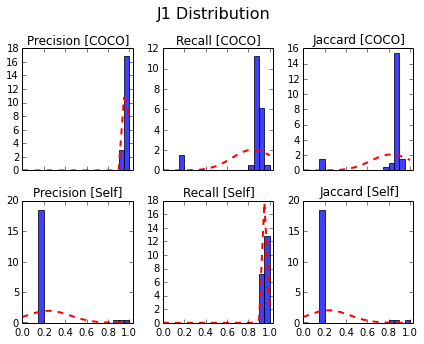

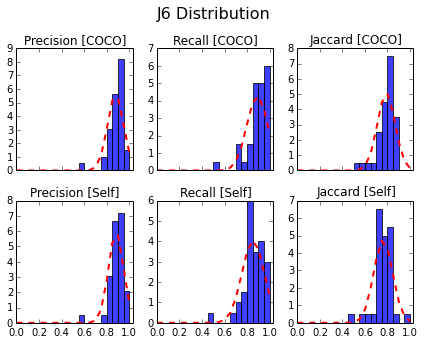

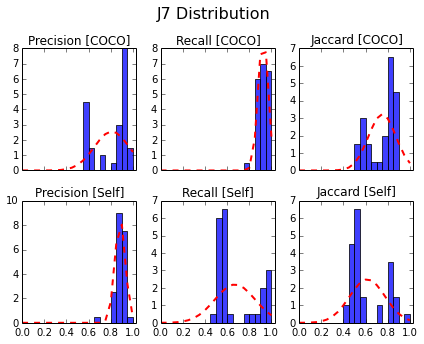

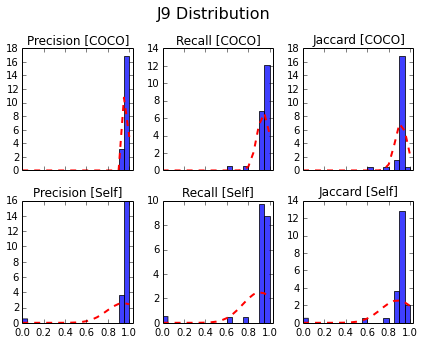

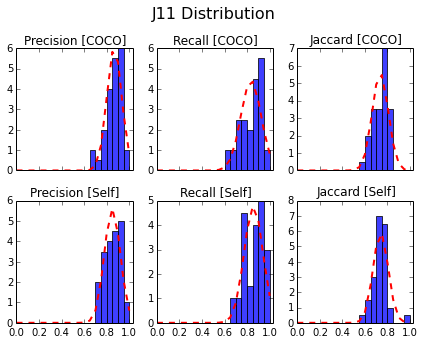

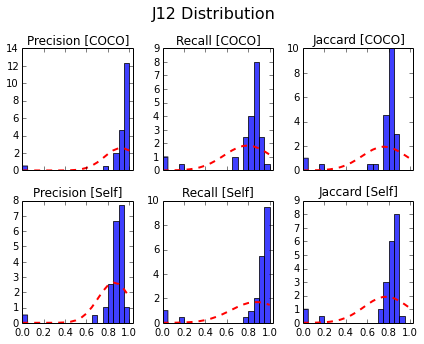

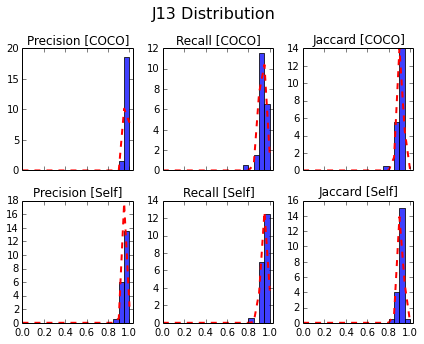

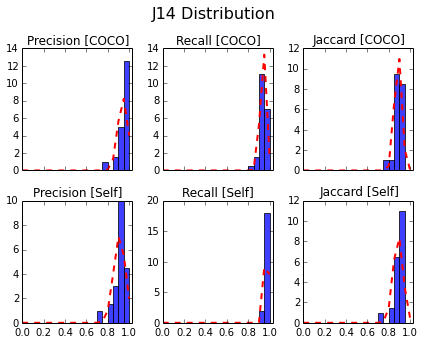

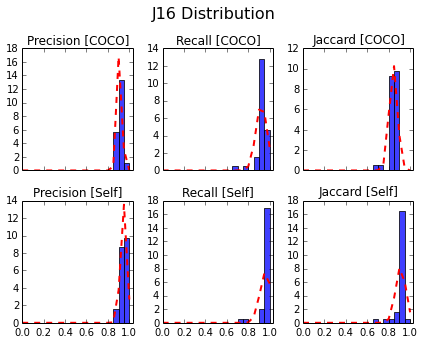

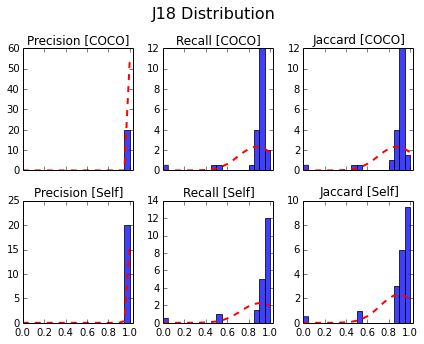

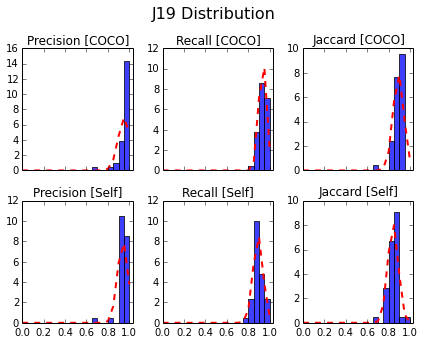

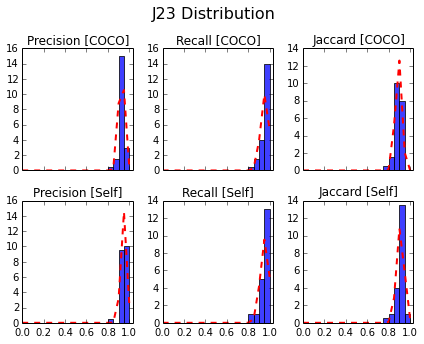

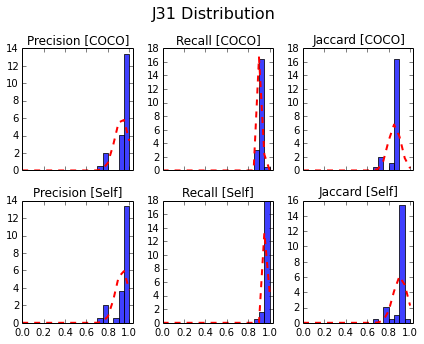

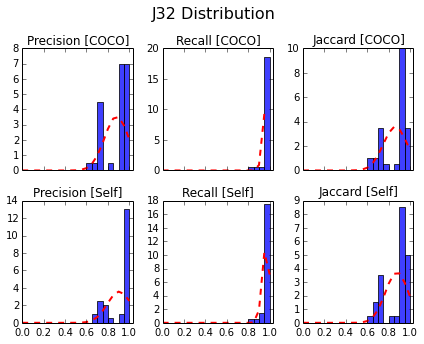

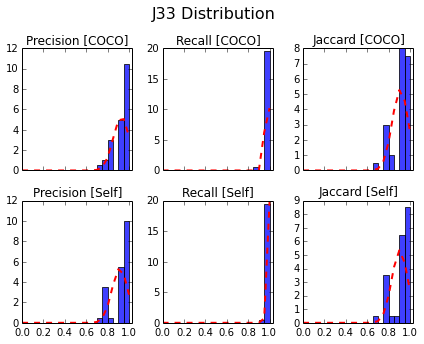

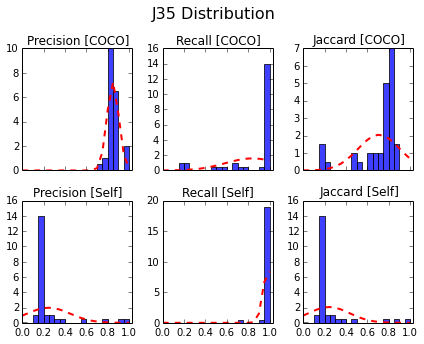

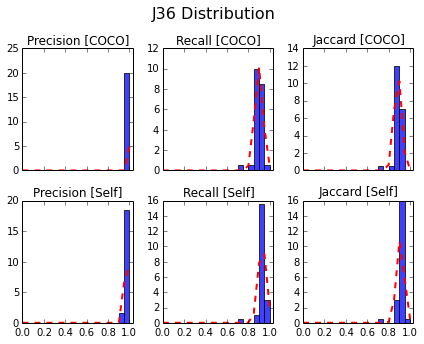

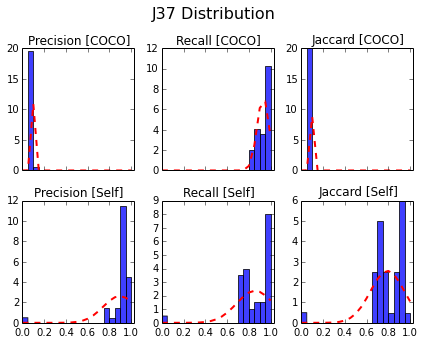

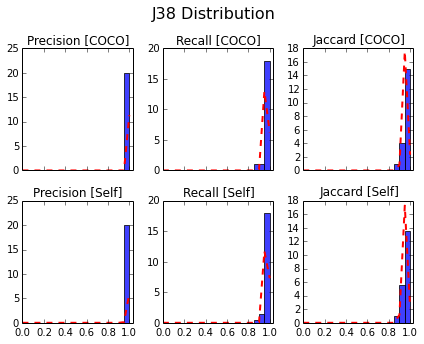

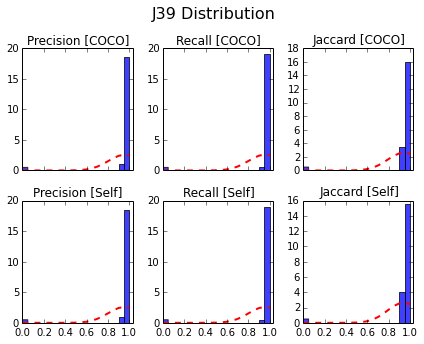

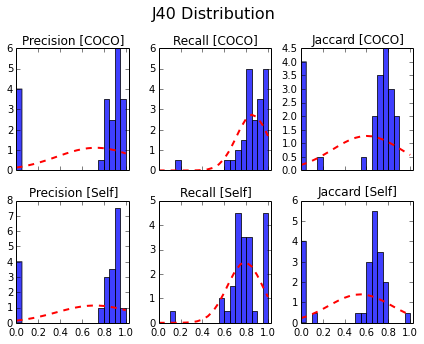

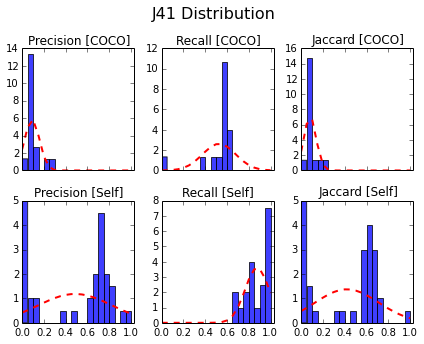

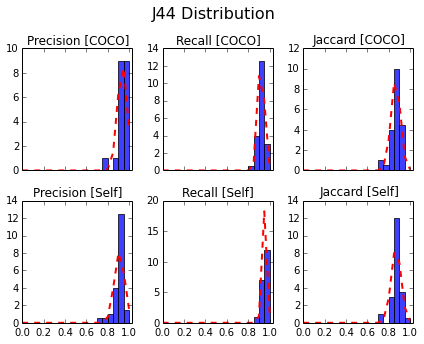

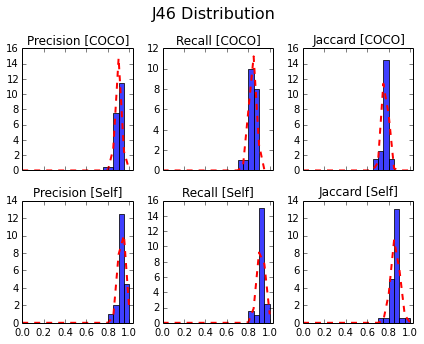

In [68]:
bin_size = 20
fcn  = stats.norm
SHOW_PLOT=True
metrics_lst = ['Precision [COCO]','Recall [COCO]','Jaccard [COCO]',\
               'Precision [Self]','Recall [Self]','Jaccard [Self]']
NUM_COL = 3
NUM_ROW = 2
NUM_PLOTS = NUM_COL*NUM_ROW
data_fit_stats=[]
for objid in object_id_lst:
    if SHOW_PLOT:
        fig, axs = plt.subplots(NUM_ROW,NUM_COL, figsize=(NUM_ROW*3,NUM_COL*1.5), sharex='col')
        stitle = fig.suptitle("J{} Distribution ".format(objid),fontsize=16,y=1.05)
        axs = axs.ravel()
    # Ji_tbl (bb_info) is the set of all workers that annotated object i 
    bb_info  = obj_sorted_tbl[obj_sorted_tbl["object_id"]==objid]
    numPoints = bb_info["x_locs"].apply(lambda x: len(ast.literal_eval(x))).mean()
    for i,metric in zip(range(len(metrics_lst)),metrics_lst):
#         table_data.append(basic_stat(metric_value,metric))
        metric_value = np.array(bb_info[metric][bb_info[metric]>0][bb_info[metric]<=1]) 
        params = fcn.fit(metric_value)
        histo,bin_edges = np.histogram(metric_value, bin_size, normed=1)
        bins = ((bin_edges+np.roll(bin_edges,-1))/2)[:-1]
        y = fcn.pdf(bins, *params)
        RSS =sum((histo-y)**2)
        ks_result = kolmogorov_smirnov(bins,y,"J"+str(objid)+metric) #D-value and p-value
        # object_id, Metric, mu, sd,RSS,D-value,p-value,numPoints
        data_stats  = [objid,metric,params[0],params[1],RSS,ks_result[1],ks_result[0],numPoints] 
        #same as what you would get if you did basic_stats because in the MLE estimate, mu and sigma is equal to sample mean and sample sd
        data_fit_stats.append(data_stats)
        if SHOW_PLOT:
            ax = axs[i]
            ax.set_title(metric)
            #ax.hist(metric_value,bins=30)
            ax.set_xlim(0,1.03)
            n, bins, patches = ax.hist(metric_value, bin_size, normed=1, range=(0,1),facecolor='blue', alpha=0.75)
            y = fcn.pdf(bins, *params)
            l = ax.plot(bins, y, 'r--', linewidth=2) 

    if SHOW_PLOT: fig.tight_layout()
# fig.savefig('{}_fitted_worker_histogram.pdf'.format(fcn.name), bbox_inches='tight',bbox_extra_artists=[stitle])

In [72]:
gaussian_fit_results =pd.DataFrame(data_fit_stats,columns=["object_id", "Metric", "Mean", "SD","RSS","D-value","p-value","Average Num Point"])

In [73]:
#The fitting is not really statistically significant, average RSS is quite large too 
print gaussian_fit_results.RSS.mean()

1337.53568157


In [74]:
len(gaussian_fit_results[gaussian_fit_results["p-value"]>0.5])

102

In [75]:
102/144.

0.7083333333333334

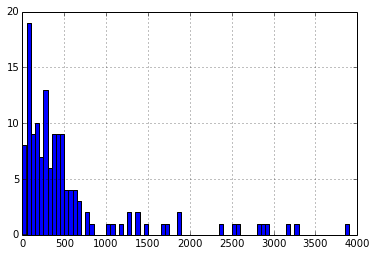

In [76]:
gaussian_fit_results.RSS.hist(bins=100,range=(0,5000))

- perform a linear regression of SD spread of distribution versus the average number of points in the plot (i.e. how hard it is to draw the BB)

In [77]:
gaussian_fit_results

,object_id,Metric,Mean,SD,RSS,D-value,p-value,Average Num Point
0,1,Precision [COCO],0.972499,0.021205,2569.527020,4.740627e-09,0.95,48.153846
1,1,Recall [COCO],0.843183,0.194542,227.145719,2.321328e-02,0.45,48.153846
2,1,Jaccard [COCO],0.823547,0.189367,261.582205,2.321328e-02,0.45,48.153846
3,1,Precision [Self],0.244087,0.202222,438.078408,5.914233e-02,0.40,48.153846
4,1,Recall [Self],0.957798,0.020984,1710.562982,5.546616e-10,1.00,48.153846
5,1,Jaccard [Self],0.240031,0.193926,434.050187,5.914233e-02,0.40,48.153846
6,6,Precision [COCO],0.878793,0.071300,56.204761,2.570614e-03,0.55,10.025000
7,6,Recall [COCO],0.890581,0.093161,42.900513,2.570614e-03,0.55,10.025000
8,6,Jaccard [COCO],0.788697,0.079127,76.696904,1.833144e-04,0.65,10.025000
9,6,Precision [Self],0.882589,0.067549,45.626199,7.252860e-04,0.60,10.025000


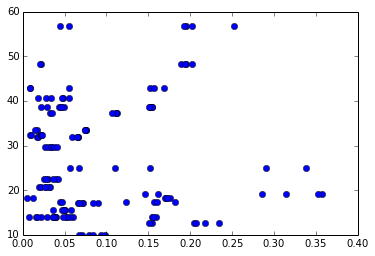

In [79]:
plt.plot(gaussian_fit_results["SD"][gaussian_fit_results["Metric"]==],gaussian_fit_results["Average Num Point"],'o')

In [83]:
metrics = list(set(gaussian_fit_results["Metric"]))

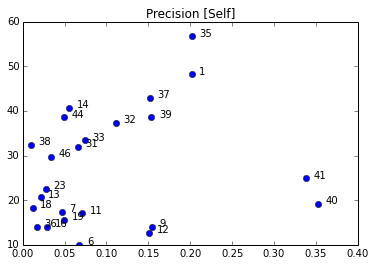

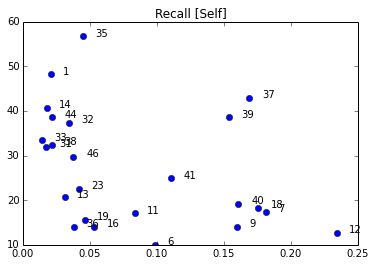

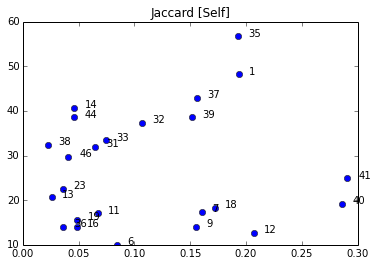

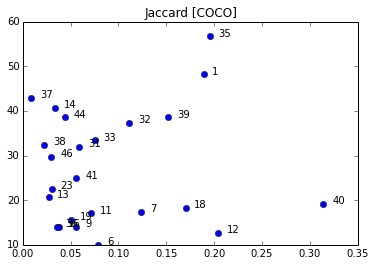

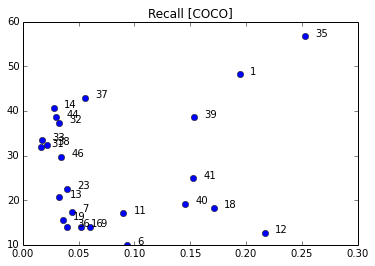

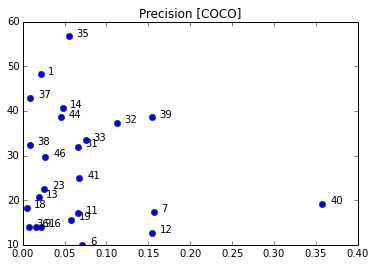

In [121]:
for metric in metrics:
    plt.figure()
    plt.title(metric)
    metric_only_fit_result = gaussian_fit_results[gaussian_fit_results["Metric"]==metric]
    plt.plot(metric_only_fit_result["SD"],metric_only_fit_result["Average Num Point"],'o')
    for row in metric_only_fit_result.iterrows():
        row = row[1]
        plt.text(row["SD"]+0.01,row["Average Num Point"]+0.01,str(row["object_id"]))

When we look at outliers, object 40 and 41 correspond to 40 driver (hard to annotate) and 

- 41 yellow bannana (task ambiguity)
- 18 monitor, although this is quite a rectangular looking object, there is also quite a few disagreement in the border regions


####To do: some objects were not included because it did not have a matching COCO, compute metric and deal with -1 and 0s still plot these in to help with the regression since having all 46 objects would be helpful 